In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../project/landmark"))

['facial_keypoints.csv', 'face_images.npz']


In [2]:
Pface = np.moveaxis(np.load('../project/landmark/face_images.npz')['face_images'],-1,0)
print Pface.shape
LMs = pd.read_csv('../project/landmark/facial_keypoints.csv')

LMpos=LMs.columns.tolist()
print(LMs.isnull().sum())

(7049, 96, 96)
left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33

In [3]:
iselect=np.nonzero(LMs.left_eye_center_x.notna() & LMs.right_eye_center_x.notna() &
         LMs.nose_tip_x.notna() & LMs.mouth_center_bottom_lip_x.notna())[0]

Spic=Pface.shape[1]
print "spic",Spic
m=iselect.shape[0]
X=np.zeros((m,Spic,Spic,1))
print X.shape
Y=np.zeros((m,8))

X[:,:,:,0]=Pface[iselect,:,:]/255.0
Y[:,0]=LMs.left_eye_center_x[iselect]/Spic
Y[:,1]=LMs.left_eye_center_y[iselect]/Spic
Y[:,2]=LMs.right_eye_center_x[iselect]/Spic
Y[:,3]=LMs.right_eye_center_y[iselect]/Spic
Y[:,4]=LMs.nose_tip_x[iselect]/Spic
Y[:,5]=LMs.nose_tip_y[iselect]/Spic
Y[:,6]=LMs.mouth_center_bottom_lip_x[iselect]/Spic
Y[:,7]=LMs.mouth_center_bottom_lip_y[iselect]/Spic

print('# selected images = %d' %(m))

/home/raghav/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


spic 96
(7000, 96, 96, 1)
# selected images = 7000


In [4]:
import matplotlib.pyplot as plt

n = 0
nrows = 4
ncols = 4
irand=np.random.choice(Y.shape[0],nrows*ncols)
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[ncols*2,nrows*2])
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X[irand[n],:,:,0], cmap='gray')
        ax[row,col].scatter(Y[irand[n],0::2]*Spic,Y[irand[n],1::2]*Spic,marker='d',c='r',s=100)
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())
        ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
        n += 1

In [5]:
from sklearn.model_selection import train_test_split

random_seed=21
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=random_seed)
print len(Xtrain)

5600


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', activation='tanh', input_shape=(Spic, Spic,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='sigmoid'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

model.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data = (Xtest, Ytest), verbose = 1)
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 23s 4ms/step - loss: 0.0472 - val_loss: 0.0246
Epoch 2/10
5600/5600 [==============================] - 18s 3ms/step - loss: 0.0171 - val_loss: 0.0054
Epoch 3/10
5600/5600 [==============================] - 19s 3ms/step - loss: 0.0261 - val_loss: 0.0056
Epoch 4/10
5600/5600 [==============================] - 18s 3ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 5/10
5600/5600 [==============================] - 18s 3ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 6/10
5600/5600 [==============================] - 19s 3ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 7/10
5600/5600 [==============================] - 18s 3ms/step - loss: 0.0020 - val_loss: 0.0

In [7]:
model.save("landmark_model.h5")
print "done"

done


(5600, 96, 96, 1)


Text(0.5,0.98,'x: Manual; +: CNN')

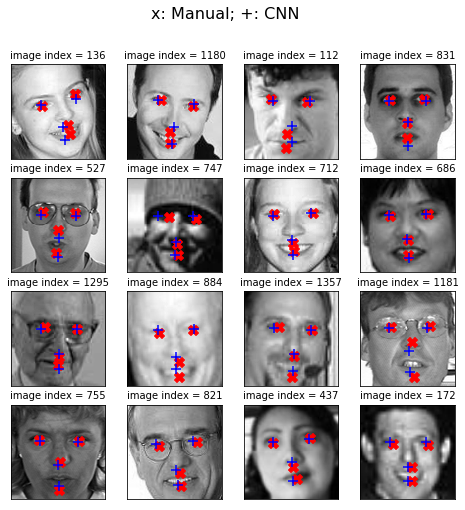

In [8]:
print Xtrain.shape
Ytrain_pred = model.predict(Xtrain)
Ytest_pred = model.predict(Xtest)

n = 0
nrows = 4
ncols = 4
irand=np.random.choice(Ytest.shape[0],nrows*ncols)
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[ncols*2,nrows*2])
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(Xtest[irand[n],:,:,0], cmap='gray')
        ax[row,col].scatter(Ytest[irand[n],0::2]*Spic,Ytest[irand[n],1::2]*Spic,marker='X',c='r',s=100)
        ax[row,col].scatter(Ytest_pred[irand[n],0::2]*Spic,Ytest_pred[irand[n],1::2]*Spic,marker='+',c='b',s=100)
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())
        ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
        n += 1
plt.suptitle('x: Manual; +: CNN', fontsize=16)